In [1]:
from load_data import get_all_generation_data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from clustering import cluster_corr, check_consistency_two_arrays, kmeans_distance
from dimensionality_reduction import pca_reduction, scale_df
from metrics.pyDRMetrics import DRMetrics
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from clustering import optimalK, evaluate_kmeans
import random

In [2]:
# DATA GENERATION
# Fetch concatenated all generation bulk molecule data
data = get_all_generation_data()
# Extract just generations 1,2 & 3
# Keep only time series data

data['time'] = data['time'].apply(lambda x: x.flatten())
data['start'] = data.time.apply(lambda x: x[0])
data['end'] = data.time.apply(lambda x: x[-1])
data['division_time'] = data['1-PFK[c]'].apply(len)
data.generation = data.generation.apply(lambda x: int(str(x)[-1]))

In [3]:
timeseries = data.copy().drop(['time', 'date_of_sim', 'cell_id', 'media', 'generation', 'gene_ko', 'tyrU-tRNA[c]', 'start', 'end', 'division_time'], axis=1)
print(timeseries.head)

<bound method NDFrame.head of             1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]  \
0    [98, 98, 98, 98, 97, 105, 109, 114, 121, 129, ...   
1    [106, 110, 112, 118, 127, 138, 147, 156, 156, ...   
2    [117, 117, 117, 117, 117, 117, 117, 116, 116, ...   
3    [83, 83, 83, 92, 99, 106, 116, 126, 138, 142, ...   
4    [55, 55, 55, 55, 55, 54, 54, 54, 61, 64, 65, 6...   
..                                                 ...   
628  [124, 124, 124, 124, 122, 122, 130, 130, 130, ...   
629  [89, 93, 104, 107, 110, 113, 122, 129, 137, 14...   
630  [79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 8...   
631  [161, 161, 161, 166, 171, 177, 185, 190, 199, ...   
632  [161, 165, 169, 174, 179, 188, 197, 209, 218, ...   

                                              1-PFK[c]  \
0    [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2...   
1    [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2...   
2    [73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 7...   
3    [14, 14, 14, 14, 14, 14, 14, 14, 14,

In [4]:
def get_timepoint_index(x, timepoint):
    try:
        return np.where(np.isclose(x.flatten(), timepoint, atol=59.9) == True)[0][0]
    except:
        return np.nan


In [5]:
def extract_timepoint_value(x, idx):
    return x.flatten()[idx]

In [6]:
timepoint = 4300.0
data['idx'] = data.time.apply(lambda x: get_timepoint_index(x, timepoint))
data_slice = data.copy().dropna()

In [7]:
# Create single timepoint data
single_timepoint_df = data_slice.drop(['time', 'date_of_sim', 'cell_id', 'media', 'generation', 'gene_ko', 'tyrU-tRNA[c]', 'idx', 'start', 'end', 'division_time'], axis=1)
for index in np.unique(data_slice.idx):
    single_timepoint_df.loc[data_slice.idx == index] = single_timepoint_df.loc[data_slice.idx == index].applymap(lambda x: int(x.flatten()[int(index)]))
single_timepoint_df = single_timepoint_df.astype('int64')
print(single_timepoint_df.head)

<bound method NDFrame.head of      1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]  1-PFK[c]  \
8                                           117        63   
9                                            83       104   
23                                          273        59   
24                                          109        73   
38                                          169        35   
..                                          ...       ...   
597                                         161        20   
611                                         170        15   
612                                         212        24   
626                                         309        36   
627                                         138        50   

     2-3-DIHYDROXYBENZOATE[c]  2-DEHYDROPANTOATE-REDUCT-MONOMER[c]  \
8                      149442                                  192   
9                      151172                                  182   
23                     1461

In [8]:
def min_max_scale(x):
    min_x = min(x)
    max_x = max(x)
    if min_x == max_x:
        return (np.zeros(shape=(1,len(x))))[0]
    else:
        return (np.array(x)-min_x)/(max_x-min_x)

In [9]:
# Scale each timeseries so that is
scaled_timeseries_df = data.drop(['time', 'date_of_sim', 'cell_id', 'media', 'generation', 'gene_ko', 'tyrU-tRNA[c]', 'idx', 'start', 'end', 'division_time'], axis=1).copy().applymap(lambda x: min_max_scale(x))

In [11]:
scaled_single_timepoint = pd.DataFrame(scale_df(single_timepoint_df), columns=single_timepoint_df.columns)

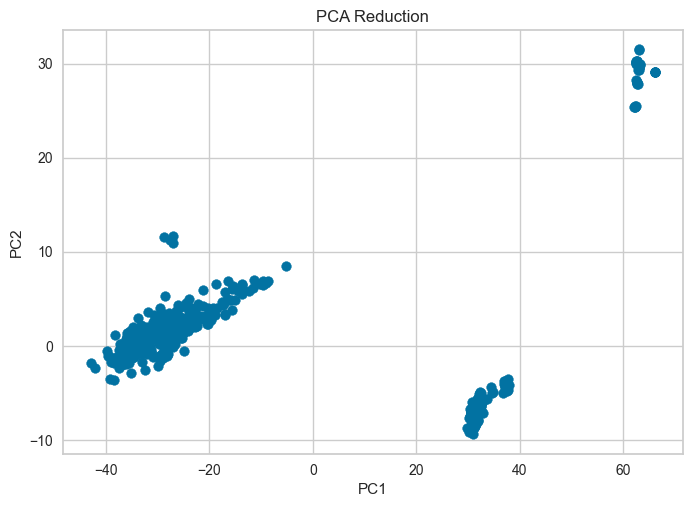

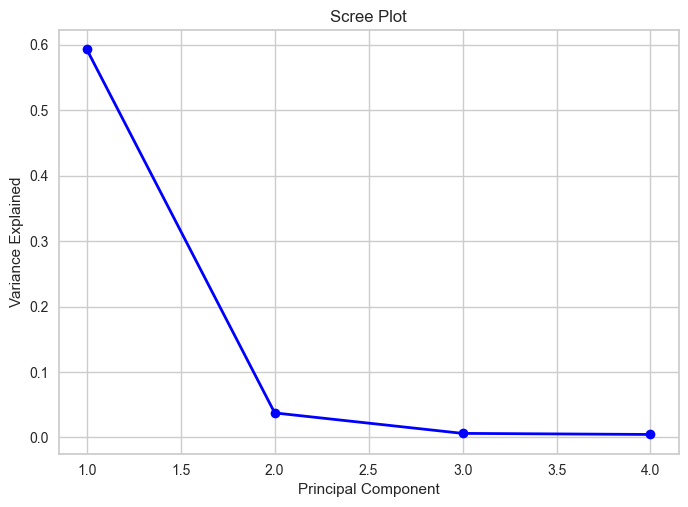

1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]
1838
                                                 PC1       PC2       PC3  \
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]  0.025635  0.002877  0.000097   
1-PFK[c]                                    0.015112  0.006265  0.010431   
2-3-DIHYDROXYBENZOATE[c]                    0.029888  0.013393  0.025580   
2-DEHYDROPANTOATE-REDUCT-MONOMER[c]         0.022242  0.000763  0.024843   
2-ISOPROPYLMALATESYN-MONOMER[c]             0.012944  0.035854  0.063145   
...                                              ...       ...       ...   
thrT-tRNA[c]                                0.028868  0.000753  0.036983   
thrU-tRNA[c]                                0.028804  0.000612  0.037430   
thrV-tRNA[c]                                0.028285  0.002988  0.057042   
trpT-tRNA[c]                                0.022497  0.078058  0.009560   
tyrT-tRNA[c]                                0.002526  0.028077  0.018747   

                                       

In [11]:
# Reduce whole differenced data set
reduced_whole_data = pca_reduction(scaled_single_timepoint, n_components=4, plot=True, get_metrics=False)

In [12]:
# VARIANCE THRESHOLD

In [19]:
# searching for features with low variance
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=1.0)
vt.fit(scaled_single_timepoint)

# find the features that meet the variance threshold
mask = vt.get_support()
chosen_features = list(single_timepoint_df.loc[:, mask].columns)
removed_features = [feature for feature in single_timepoint_df.columns if feature not in chosen_features]

# show the chosen and removed features
print('Chosen features: {}'.format(len(chosen_features)))
print('Removed features: {}'.format(len(removed_features)))

Chosen features: 322
Removed features: 1516


In [20]:
N_select = 60
selected_bms = random.sample(chosen_features, N_select)
variance_selected_data = scaled_single_timepoint[chosen_features]

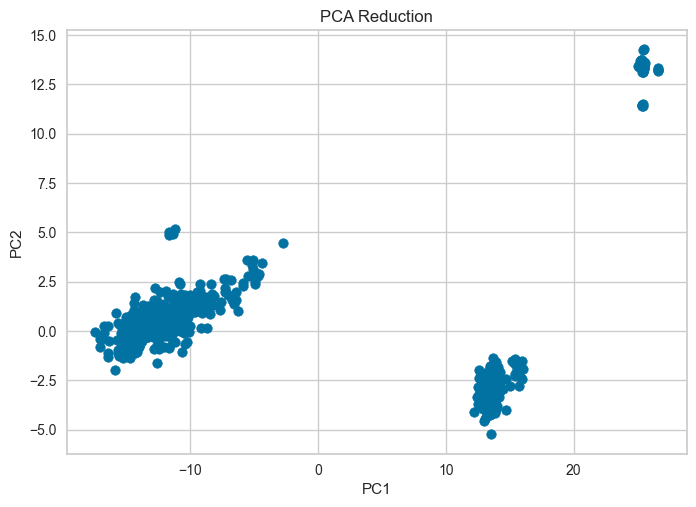

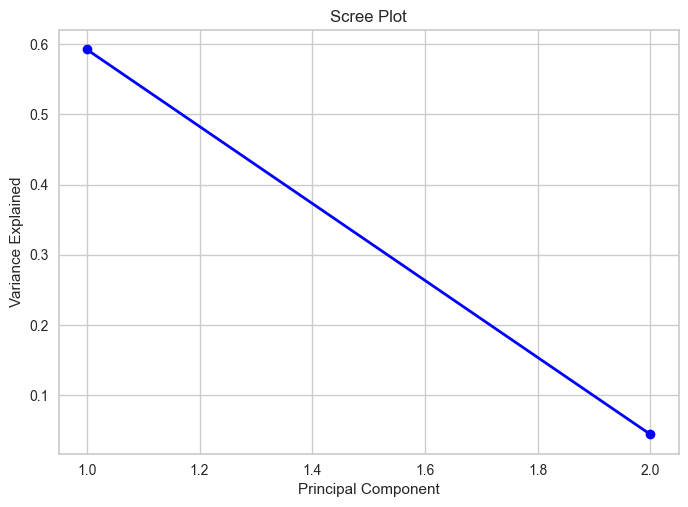

1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]
322
                                                 PC1       PC2
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]  0.061248  0.010704
3-METHYL-2-OXOBUT-OHCH3XFER-CPLX[c]         0.064715  0.012625
ABC-27-CPLX[i]                              0.045097  0.010286
ABC-304-CPLX[i]                             0.061097  0.012317
ACETOACETYL-COA[c]                          0.069061  0.028475
...                                              ...       ...
proM-tRNA[c]                                0.069414  0.022523
serU-tRNA[c]                                0.062318  0.069818
thrT-tRNA[c]                                0.068958  0.003222
thrU-tRNA[c]                                0.068785  0.003422
trpT-tRNA[c]                                0.054618  0.167475

[322 rows x 2 columns]
Time taken to generate ranking dataframe: 27.34s
Time taken to convert to matrix: 0.0s
Time taken to generate ranking dataframe: 28.11s
Time taken to convert to matrix: 0.0s

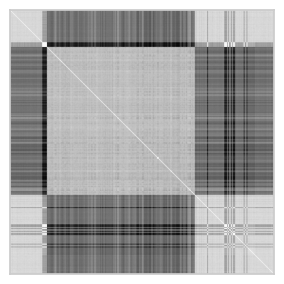

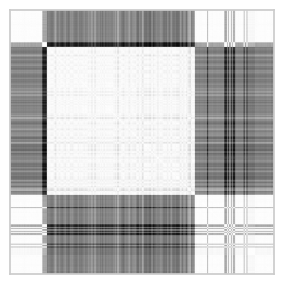

Residual Variance (using Pearson's r) =  0.07087877401118703
Residual Variance (using Spearman's r) =  0.07949169224631458
--- Ranking Matrices (R and Rz) ---


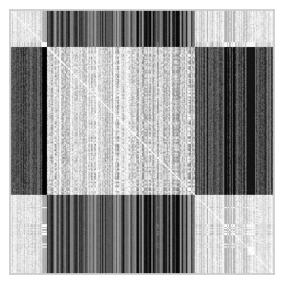

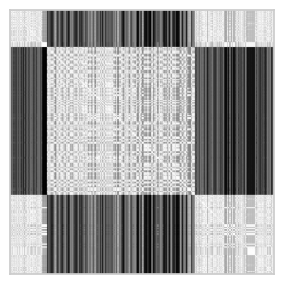

--- Co-ranking Matrix (Q) ---


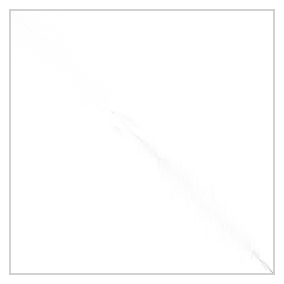

--- Trustworthiness T(k) and Continuity C(k) ---


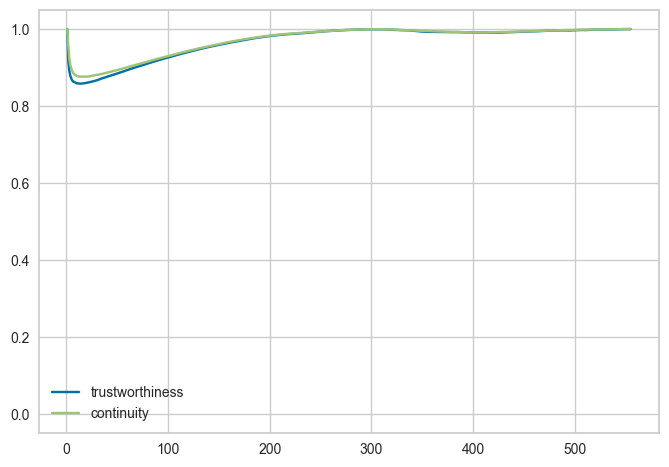

AUC of T =  0.9688188924517205
AUC of C =  0.9714898247054919
--- QNN(k) Curve ---


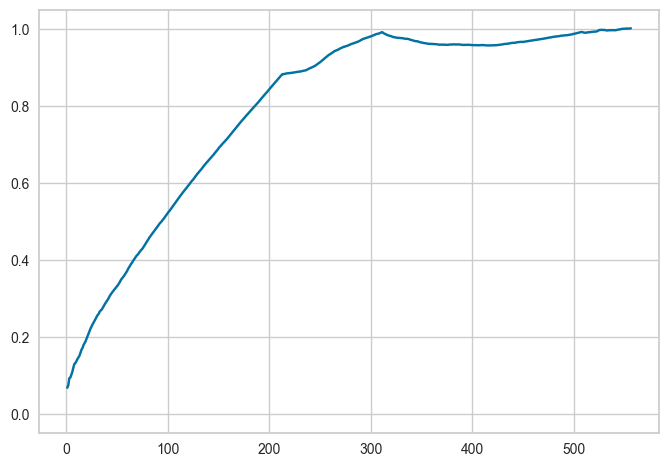

AUC of QNN =  0.7968935435686656
--- LCMC(k) Curve ---


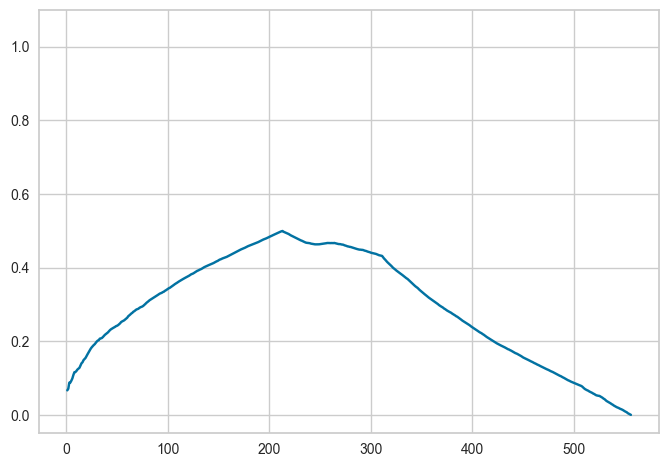

kmax (0-based index) =  212
Qlocal =  0.529377083176675
Qglobal =  0.9626727237662674
None


array([[13.18411453, -3.5021017 ],
       [13.58383588, -3.24776201],
       [13.53003951, -2.20420784],
       ...,
       [13.45753029, -2.64858872],
       [13.56684053, -2.95518007],
       [13.36774073, -3.30959307]])

In [21]:
pca_reduction(variance_selected_data)

In [14]:
# SPEARMAN CORRELATION

max pairwise dist:  58.168165268089915
cluster values:  [17 64 13 ... 15 96 25]
n clusters:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102]


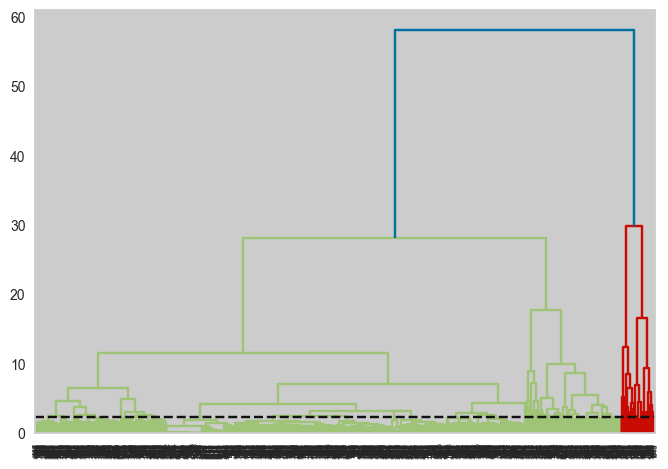

In [15]:
spearman_corr_matrix = single_timepoint_df.corr(method ='spearman', numeric_only=True)
spearman_corr_matrix = spearman_corr_matrix.replace(np.nan, 0)
clustered_spearman_corr_matrix, spearman_clusters_idx = cluster_corr(spearman_corr_matrix, threshold_ratio=0.04)

<AxesSubplot: >

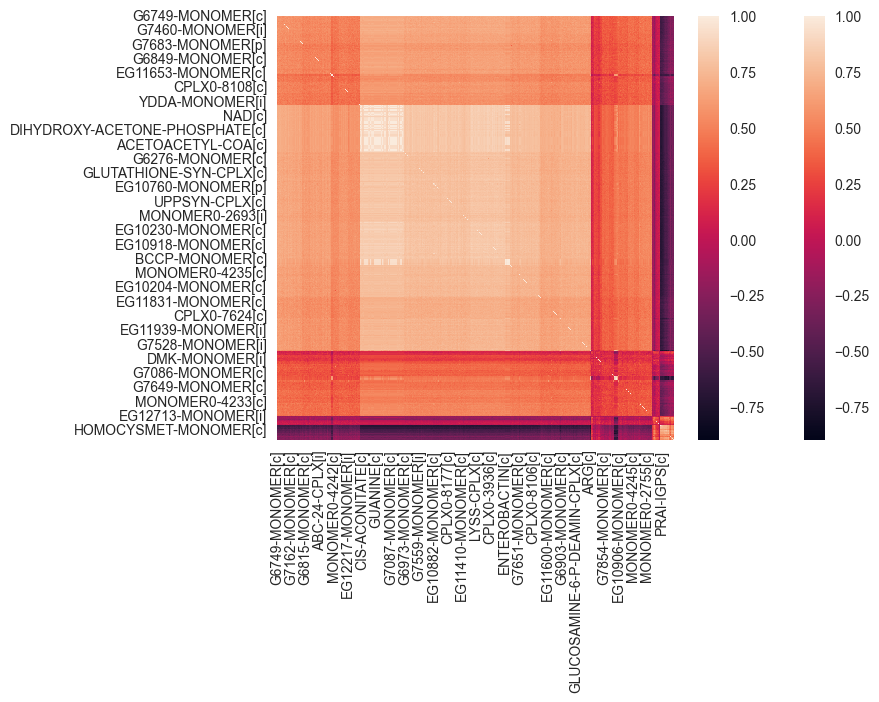

In [16]:
sns.heatmap(spearman_corr_matrix)
sns.heatmap(clustered_spearman_corr_matrix)

In [17]:
# Create new column containing cluster labels
unique_clusters = np.unique(spearman_clusters_idx)
spearman_corr_matrix['cluster'] = spearman_clusters_idx

selected_bms = []
for label in unique_clusters:
    # Get first bulk molecule from each cluster
    first_bm = spearman_corr_matrix.loc[spearman_corr_matrix['cluster'] == label].index.values[0]
    selected_bms.append(first_bm)

print(selected_bms)

['ABC-21-CPLX[i]', 'ABC-62-CPLX[i]', 'GUANOSINE-5DP-3DP[c]', 'selC-tRNA[c]', 'AMYLOMALT-MONOMER[c]', 'ABC-13-CPLX[i]', 'argQ-tRNA[c]', 'B1596-MONOMER[i]', 'EG11964-MONOMER[c]', 'BCR-MONOMER[i]', 'EG10868-MONOMER[c]', 'COBS-MONOMER[i]', '2-3-DIHYDROXYBENZOATE[c]', '2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER[c]', '6PFK-1-CPX[c]', 'BIOTIN[c]', '1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]', '2-DEHYDROPANTOATE-REDUCT-MONOMER[c]', '3-ISOPROPYLMALDEHYDROG-CPLX[c]', '7-ALPHA-HYDROXYSTEROID-DEH-CPLX[c]', 'ARG[c]', 'GLT[c]', 'CPLX0-3921[c]', 'CPLX0-1941[i]', 'hisR-tRNA[c]', 'CPLX0-3121[c]', 'EG10374-MONOMER[p]', 'G6741-MONOMER[c]', 'DIAMINOPIMDECARB-CPLX[c]', 'CPLX0-3957[c]', 'EG10238-MONOMER[c]', 'EG10889-MONOMER[c]', 'EG11876-MONOMER[c]', 'CPLX0-7687[c]', 'EG11822-MONOMER[c]', 'DMK-MONOMER[i]', 'G6970-MONOMER[c]', 'ARTI-MONOMER[p]', 'EG10917-MONOMER[c]', 'LIVJ-MONOMER[p]', 'GLN[c]', 'EG10864-MONOMER[c]', 'CPLX0-1221[c]', 'GABATRANSAM-CPLX[c]', 'EG11231-MONOMER[c]', 'RELA-MONOMER[c]', '6PGLUCONDEH

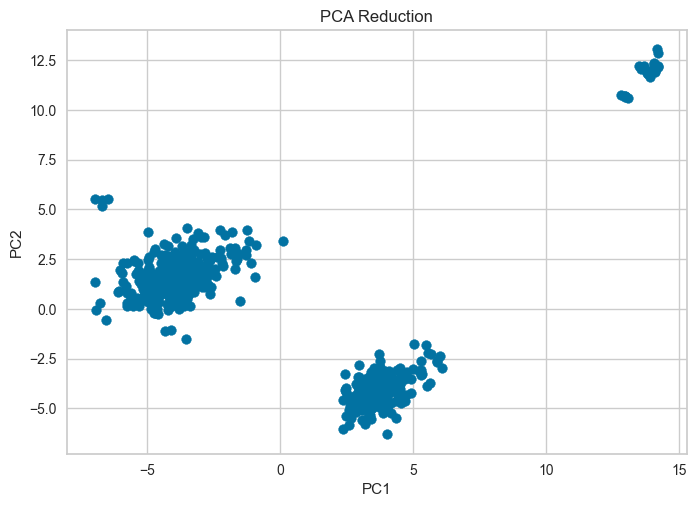

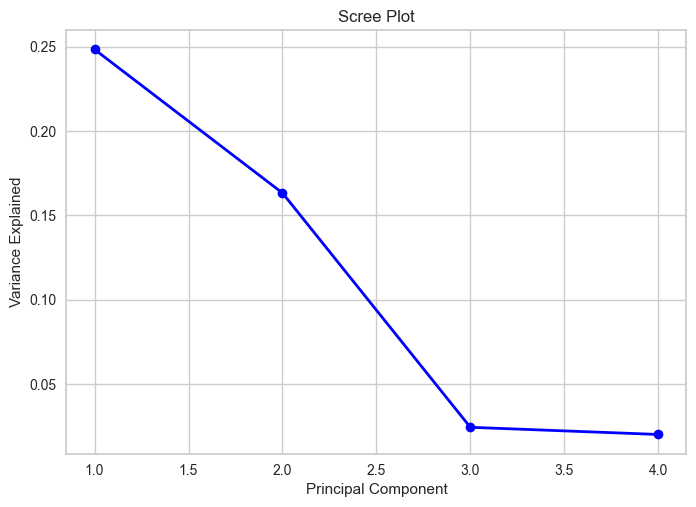

ABC-21-CPLX[i]
102
                                      PC1       PC2       PC3       PC4
ABC-21-CPLX[i]                   0.129676  0.040220  0.123117  0.078100
ABC-62-CPLX[i]                   0.139387  0.031388  0.042691  0.113231
GUANOSINE-5DP-3DP[c]             0.151195  0.053366  0.058580  0.141741
selC-tRNA[c]                     0.147397  0.081856  0.080264  0.049335
AMYLOMALT-MONOMER[c]             0.108907  0.054452  0.041133  0.004737
...                                   ...       ...       ...       ...
ACETYLORNDEACET-CPLX[c]          0.066703  0.137963  0.013217  0.027506
ABC-26-CPLX[i]                   0.038980  0.110203  0.004811  0.079863
EG11449-MONOMER[c]               0.048120  0.114784  0.010161  0.010116
ASPKINIHOMOSERDEHYDROGI-CPLX[c]  0.006338  0.204090  0.107304  0.019766
ARTJ-MONOMER[p]                  0.049902  0.152936  0.026669  0.014447

[102 rows x 4 columns]


In [18]:
# Filter only single bulk molecules from each cluster
feature_selected_data = scaled_single_timepoint[selected_bms]
# Measure how well PCA works with only feature selected data
reduced_selected_data = pca_reduction(feature_selected_data, n_components=4, plot=True, get_metrics=False)

In [19]:
drm = DRMetrics(reduced_whole_data, reduced_selected_data)
print(drm.report()) # print out the summary

Time taken to generate ranking dataframe: 46.74s
Time taken to convert to matrix: 0.0s


KeyboardInterrupt: 

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

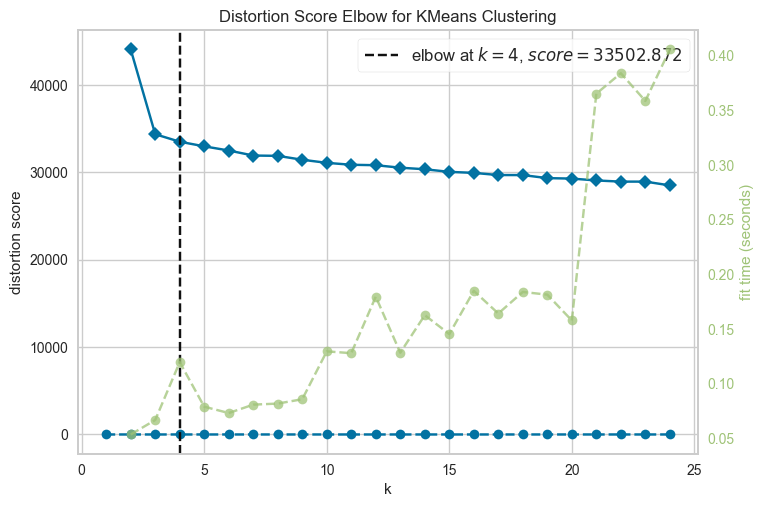

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

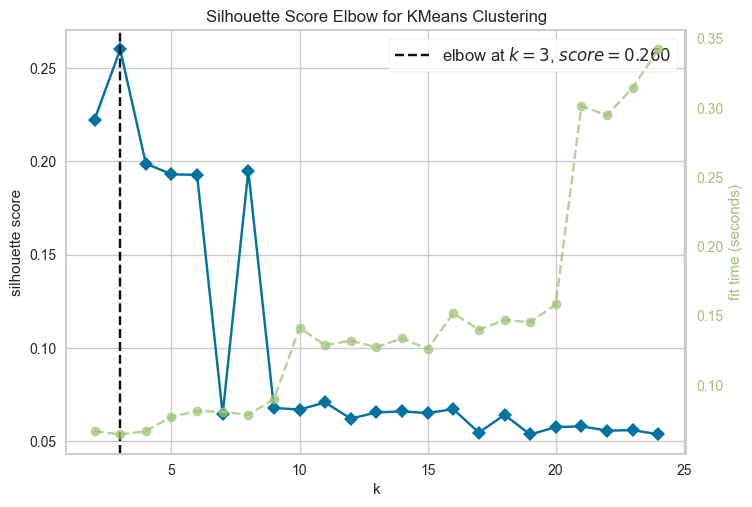

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

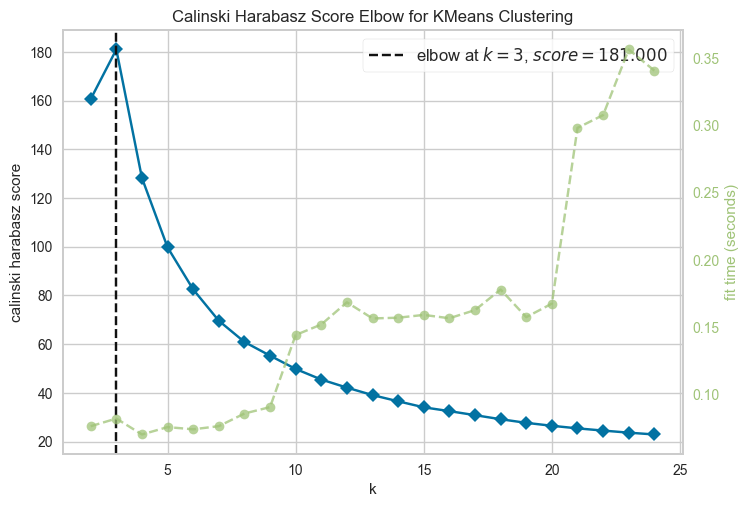

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

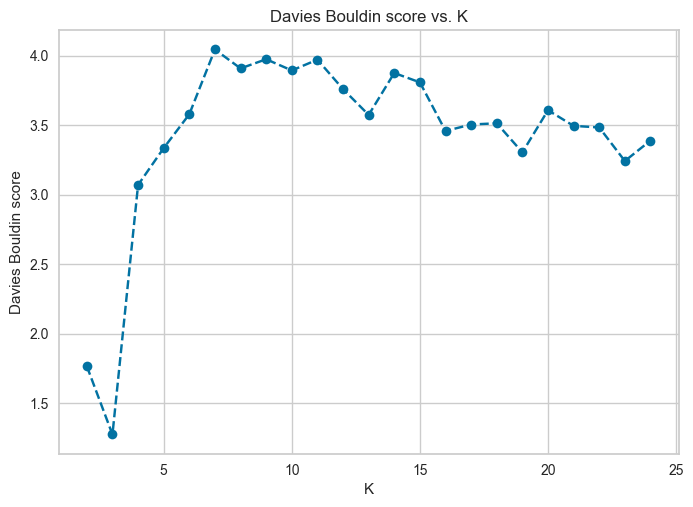

In [64]:
evaluate_kmeans(feature_selected_data, max_clusters=25)

In [20]:
# DTW SELECTION

In [21]:
from dtaidistance import dtw
from tslearn.preprocessing import TimeSeriesResampler
from clustering import resample_column

In [22]:
# def generate_pairwise_dtw_cost_matrix(cell_data):
#     """Creates matrix dataframe of pairwise dtw cost between bulk molecule time series for a single cell"""
#     dtw_cost_dict = {}
#     normalised_sample_data = cell_data.apply(lambda x: [item for sublist in normalise_and_resample_column(column=x, sample_size=25)[0] for item in sublist], axis=1)
#     counter = 0
#     for index, row in normalised_sample_data.items():
#         dtw_costs = normalised_sample_data.apply(lambda x: dtw.distance(row, x))
#         dtw_cost_dict[str(index)] = dtw_costs
#         counter += 1
#         if counter % 100 == 0:
#             print(round((counter/1838) * 100,3), "% complete")
#     print("completed.")
#     pairwise_dtw_cost_df = pd.DataFrame(dtw_cost_dict)
#
#     return pairwise_dtw_cost_df

In [39]:
def generate_pairwise_dtw_cost_matrix(cell_data):
    """Creates matrix dataframe of pairwise dtw cost between bulk molecule time series for a single cell"""
    resampler = TimeSeriesResampler(sz=25)
    resampled_data = cell_data.apply(lambda x: [v for v in resampler.fit_transform(x)[0].ravel()])
    print("resampled:\n",resampled_data)
    pairwise_cost_df = squareform(pdist(pd.DataFrame.from_dict(dict(zip(cell_data.index, resampled_data))).T, lambda u, v: dtw.distance(u,v)))

    return pairwise_cost_df

In [40]:
# CLUSTER AVERAGED DTW COSTS ACROSS SAMPLE OF CELLS

N = 5
avg_pairwise_dtw_dist = pd.DataFrame(generate_pairwise_dtw_cost_matrix(scaled_timeseries_df.copy().T.iloc[:,0]), index=timeseries.columns, columns=timeseries.columns)
for i in range(N-1):
    pairwise_dtw_dist = pd.DataFrame(generate_pairwise_dtw_cost_matrix(scaled_timeseries_df.copy().T.iloc[:,i]), index=timeseries.columns, columns=timeseries.columns)
    avg_pairwise_euclidean_dist = avg_pairwise_dtw_dist.add(pairwise_dtw_dist)

avg_pairwise_dtw_dist = avg_pairwise_dtw_dist / N

resampled:
 1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]    [0.003745318352059925, 0.003745318352059925, 0...
1-PFK[c]                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2-3-DIHYDROXYBENZOATE[c]                      [0.0, 0.03363493280535228, 0.0640613777976202,...
2-DEHYDROPANTOATE-REDUCT-MONOMER[c]           [0.0, 0.046009771986970684, 0.0662323561346362...
2-ISOPROPYLMALATESYN-MONOMER[c]               [0.0, 0.020323129251700676, 0.0586734693877550...
                                                                    ...                        
thrT-tRNA[c]                                  [0.5441176470588235, 0.6323529411764706, 0.697...
thrU-tRNA[c]                                  [0.4339622641509434, 0.6226415094339622, 0.644...
thrV-tRNA[c]                                  [0.6410256410256411, 0.7532051282051283, 0.670...
trpT-tRNA[c]                                  [1.0, 0.7473147153598282, 0.5281059792337988, ...
tyrT-tRNA[c]                

max pairwise dist:  30.643160254890276
cluster values:  [52 23 50 ... 35 17 35]
n clusters:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]


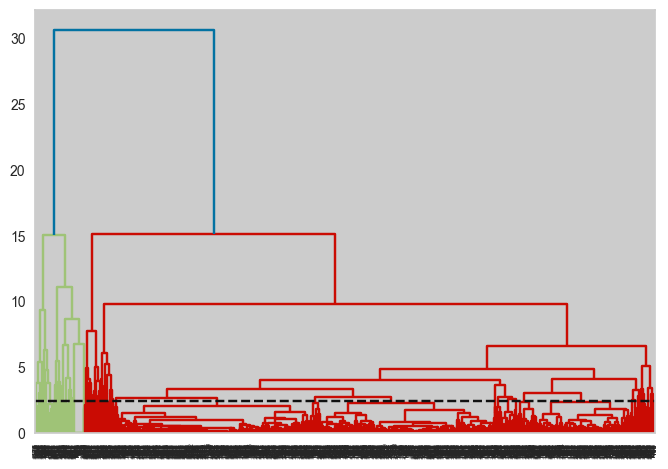

In [41]:
# Cluster bulk molecules using pairwise DTW costs
clustered_pairwise_dtw_cost_matrix, clusters_idx = cluster_corr(avg_pairwise_dtw_dist, threshold_ratio=0.08)

In [42]:
# Create new column containing cluster labels
unique_clusters = np.unique(clusters_idx)
clustered_pairwise_dtw_cost_matrix['cluster'] = clusters_idx

selected_bms = []
for label in unique_clusters:
    first_bm = clustered_pairwise_dtw_cost_matrix.loc[clustered_pairwise_dtw_cost_matrix['cluster'] == label].index.values[0]
    selected_bms.append(first_bm)

# COULD TRY RANDOMLY SAMPLING BMS FROM EACH CLUSTER AND ANALYSING CLUSTER CONSISTENCY OR KRUSKALS STRESS TO VERIFY BMS REPRESENT SAME VARIANCE IN DATA

# COULD TRY APPLYING TO MULTIPLE CELLS AND COMPARING CLUSTER CONSISTENCY
print(selected_bms)

['G6935-MONOMER[c]', 'CTP[c]', 'FLAVODOXIN2-MONOMER[c]', 'MG+2[c]', 'G7804-MONOMER[c]', 'CPLX0-7735[c]', 'EG11570-MONOMER[i]', 'GUANYL-KIN-CPLX[c]', 'PC00084[c]', 'YHHO-MONOMER[i]', 'CPLX0-8177[c]', 'PD00260[c]', 'NAG1P-URIDYLTRANS-CPLX[c]', 'G7373-MONOMER[c]', 'argU-tRNA[c]', 'DEOXYADENOSINE[c]', 'G7883-MONOMER[c]', 'CPLX0-245[c]', 'EG12176-MONOMER[c]', 'G6875-MONOMER[i]', 'FERREDOXIN-MONOMER[c]', 'OROTPDECARB-CPLX[c]', 'G6725-MONOMER[c]', 'PD01520[c]', 'POTA-MONOMER[i]', 'GLYOHMETRANS-CPLX[c]', 'RIBULOSE-5P[c]', 'EG11470-MONOMER[c]', 'GLYCEROL-KIN-CPLX[c]', 'SFUA-MONOMER[p]', 'G6125-MONOMER[c]', 'EG11119-MONOMER[c]', 'THRS-CPLX[c]', 'PHOP-MONOMER[c]', 'CYOC-MONOMER[i]', 'EG11199-MONOMER[c]', 'LYSP-MONOMER[i]', 'EG11450-MONOMER[c]', 'EG10910-MONOMER[c]', 'DIHYDROFOLATEREDUCT-MONOMER[c]', 'G7873-MONOMER[i]', 'GLYQ-MONOMER[c]', 'MONOMER0-4228[c]', 'CPLX0-8016[c]', 'G7683-MONOMER[p]', 'argQ-tRNA[c]', 'METHYLENETHFREDUCT-CPLX[c]', 'EG10108-MONOMER[c]', 'EG11166-MONOMER[c]', 'G7648-MONOMER

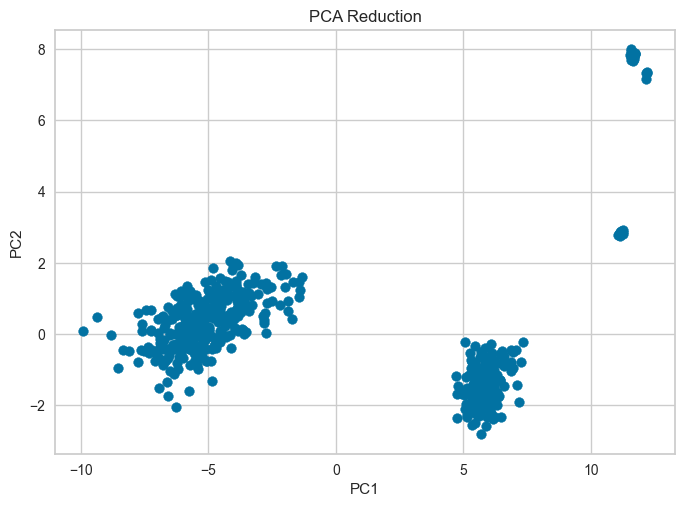

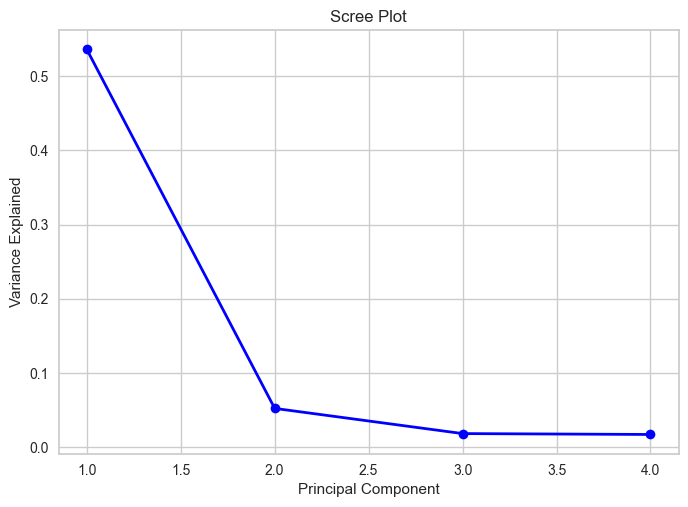

G6935-MONOMER[c]
68
                             PC1       PC2       PC3       PC4
G6935-MONOMER[c]        0.079052  0.002425  0.060268  0.216823
CTP[c]                  0.162477  0.064740  0.018432  0.015202
FLAVODOXIN2-MONOMER[c]  0.143005  0.012980  0.019292  0.095139
MG+2[c]                 0.156425  0.060309  0.035129  0.044108
G7804-MONOMER[c]        0.024710  0.376389  0.024812  0.006203
...                          ...       ...       ...       ...
G6475-MONOMER[c]        0.144483  0.017961  0.023191  0.018250
RSTB-MONOMER[i]         0.103019  0.001310  0.141985  0.056162
charged-proM-tRNA[c]    0.161326  0.083469  0.014890  0.007784
CPLX0-7422[c]           0.078877  0.060805  0.176113  0.098024
EG12851-MONOMER[c]      0.098055  0.135103  0.053213  0.071241

[68 rows x 4 columns]


In [43]:
# Filter only single bulk molecules from each cluster
dtw_feature_selected_data = scaled_single_timepoint[selected_bms]
reduced_dtw_selected_data = pca_reduction(dtw_feature_selected_data, n_components=4, plot=True, get_metrics=False)

Time taken to generate ranking dataframe: 26.97s
Time taken to convert to matrix: 0.0s
Time taken to generate ranking dataframe: 27.25s
Time taken to convert to matrix: 0.0s
[[  0  25  51 ... 155 107 149]
 [ 69   0  80 ... 153  56  90]
 [135  99   0 ... 107 140 164]
 ...
 [186 159  95 ...   0  80 100]
 [166  48 117 ...  57   0  33]
 [188  77 128 ...  71  17   0]]
[[  0   5  16 ...  51  25  69]
 [ 27   0 135 ...  62  22  47]
 [  4  15   0 ...  80  24  79]
 ...
 [117  56 194 ...   0 142  19]
 [ 82  13 161 ... 167   0  84]
 [191 112 205 ...  73 144   0]]
R1 shape: (557, 557)
R2 shape: (557, 557)
--- Distance Matrices (D and Dz) ---


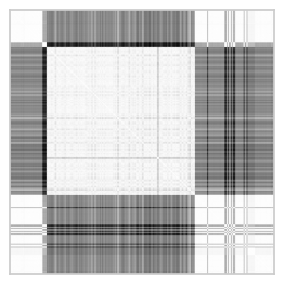

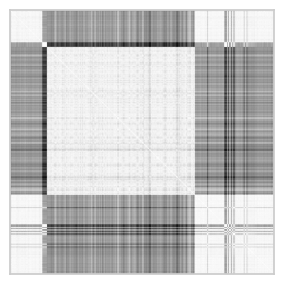

Residual Variance (using Pearson's r) =  0.04794280998721001
Residual Variance (using Spearman's r) =  0.11983666323178599
--- Ranking Matrices (R and Rz) ---


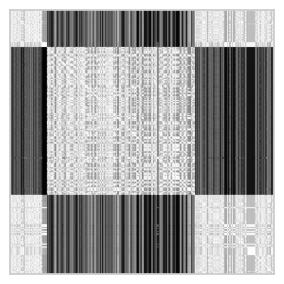

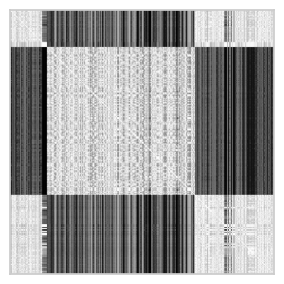

--- Co-ranking Matrix (Q) ---


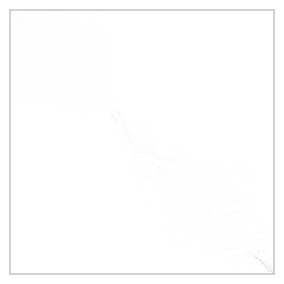

--- Trustworthiness T(k) and Continuity C(k) ---


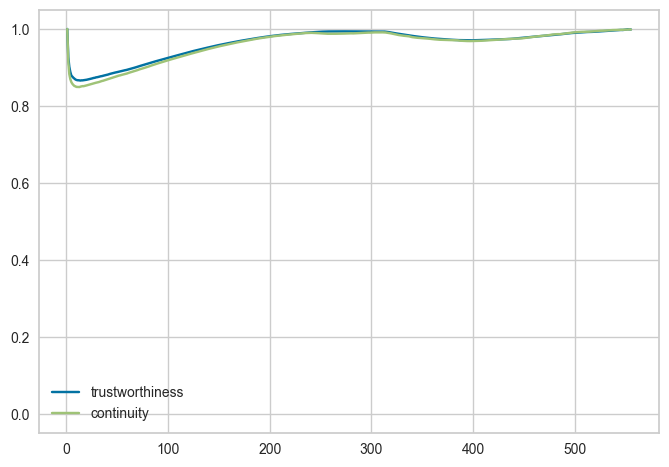

AUC of T =  0.9633976077741949
AUC of C =  0.9598481282553898
--- QNN(k) Curve ---


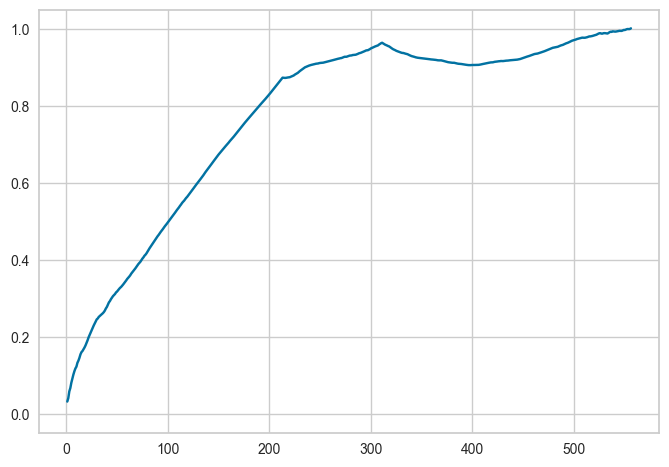

AUC of QNN =  0.7727716689299993
--- LCMC(k) Curve ---


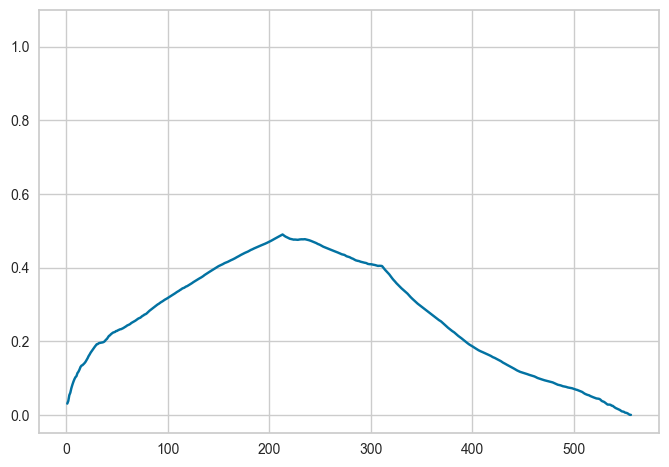

kmax (0-based index) =  212
Qlocal =  0.5110225689416887
Qglobal =  0.9349419443892819
None


In [44]:
drm = DRMetrics(reduced_whole_data, reduced_dtw_selected_data)
print(drm.report()) # print out the summary

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

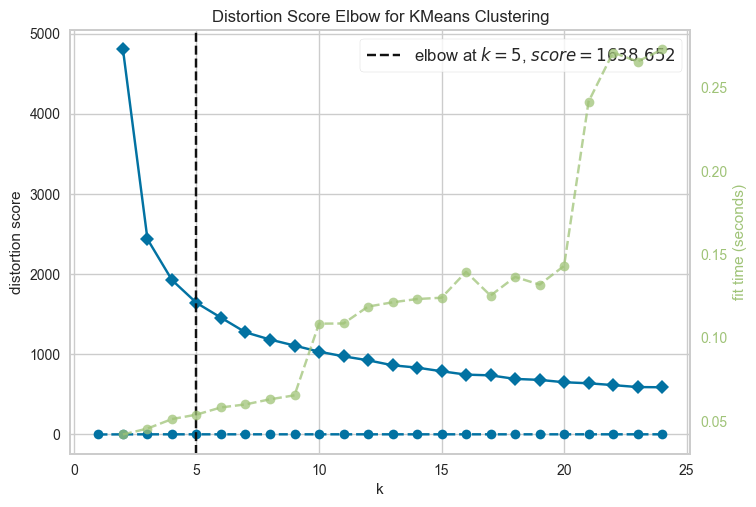

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

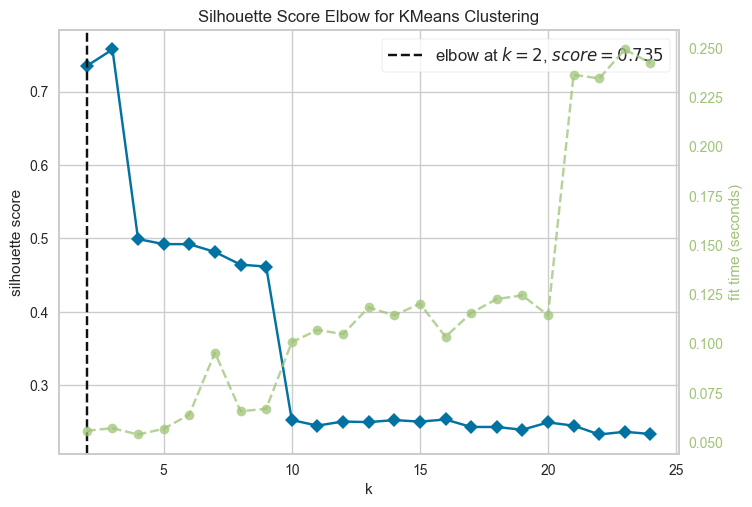

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

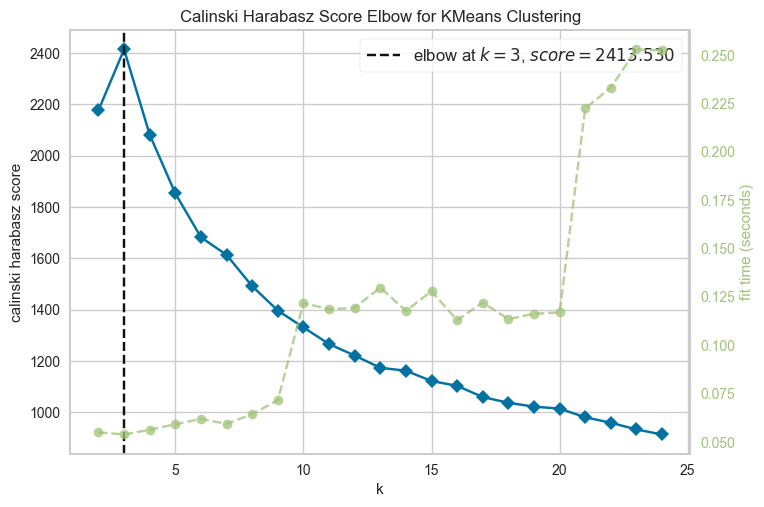

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

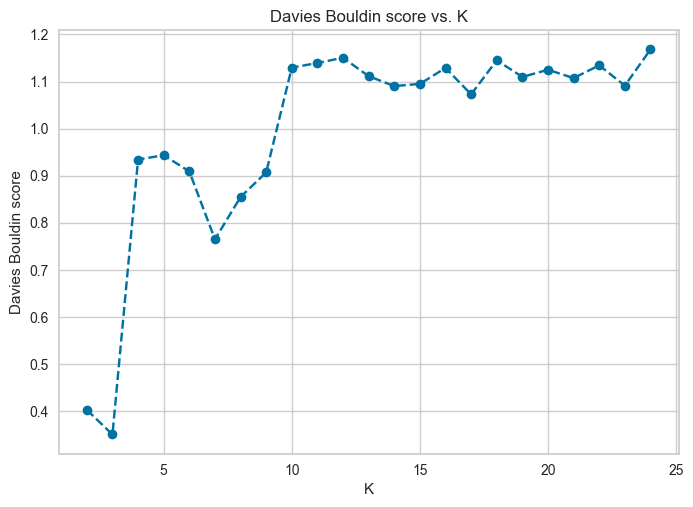

In [65]:
evaluate_kmeans(reduced_dtw_selected_data, max_clusters=25)

In [45]:
# EUCLIDEAN TIME SERIES DISTANCE

In [48]:
def generate_pairwise_euclidean_cost_matrix(cell_data):
    """Creates matrix dataframe of pairwise euclidean cost between bulk molecule time series for a single cell"""
    pairwise_cost_df = squareform(pdist(pd.DataFrame.from_dict(dict(zip(cell_data.index, cell_data.values))).T, 'euclidean'))

    return pairwise_cost_df

In [49]:
print(timeseries.T.iloc[:,0])

1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]    [98, 98, 98, 98, 97, 105, 109, 114, 121, 129, ...
1-PFK[c]                                      [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2...
2-3-DIHYDROXYBENZOATE[c]                      [93898, 95990, 97725, 99466, 101236, 103048, 1...
2-DEHYDROPANTOATE-REDUCT-MONOMER[c]           [159, 166, 175, 177, 181, 186, 190, 198, 204, ...
2-ISOPROPYLMALATESYN-MONOMER[c]               [383, 389, 394, 403, 418, 433, 445, 454, 464, ...
                                                                    ...                        
thrT-tRNA[c]                                  [39, 45, 45, 50, 49, 40, 9, 47, 22, 47, 32, 31...
thrU-tRNA[c]                                  [26, 36, 36, 36, 38, 28, 4, 36, 18, 36, 22, 21...
thrV-tRNA[c]                                  [28, 30, 33, 28, 30, 23, 8, 28, 11, 30, 18, 21...
trpT-tRNA[c]                                  [969, 691, 745, 616, 468, 366, 282, 281, 229, ...
tyrT-tRNA[c]                            

In [50]:
print(scaled_timeseries_df.copy().T.iloc[:,0])

1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]    [0.003745318352059925, 0.003745318352059925, 0...
1-PFK[c]                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2-3-DIHYDROXYBENZOATE[c]                      [0.0, 0.02030397732787235, 0.03714307898363647...
2-DEHYDROPANTOATE-REDUCT-MONOMER[c]           [0.0, 0.02280130293159609, 0.05211726384364821...
2-ISOPROPYLMALATESYN-MONOMER[c]               [0.0, 0.012244897959183673, 0.0224489795918367...
                                                                    ...                        
thrT-tRNA[c]                                  [0.5441176470588235, 0.6323529411764706, 0.632...
thrU-tRNA[c]                                  [0.4339622641509434, 0.6226415094339622, 0.622...
thrV-tRNA[c]                                  [0.6410256410256411, 0.6923076923076923, 0.769...
trpT-tRNA[c]                                  [1.0, 0.7013963480128894, 0.7593984962406015, ...
tyrT-tRNA[c]                            

In [51]:
N = 500
avg_pairwise_euclidean_dist = pd.DataFrame(generate_pairwise_euclidean_cost_matrix(scaled_timeseries_df.copy().T.iloc[:,0]), index=timeseries.columns, columns=timeseries.columns)
for i in range(N-1):
    pairwise_euclidean_dist = pd.DataFrame(generate_pairwise_euclidean_cost_matrix(scaled_timeseries_df.copy().T.iloc[:,i]), index=timeseries.columns, columns=timeseries.columns)
    avg_pairwise_euclidean_dist = avg_pairwise_euclidean_dist.add(pairwise_euclidean_dist)

avg_pairwise_euclidean_dist = avg_pairwise_euclidean_dist / N

In [52]:
print(avg_pairwise_euclidean_dist)

                                            1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]  \
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]                                    0.000000   
1-PFK[c]                                                                      2.960283   
2-3-DIHYDROXYBENZOATE[c]                                                      1.597903   
2-DEHYDROPANTOATE-REDUCT-MONOMER[c]                                           2.237378   
2-ISOPROPYLMALATESYN-MONOMER[c]                                               2.162515   
...                                                                                ...   
thrT-tRNA[c]                                                                  2.026396   
thrU-tRNA[c]                                                                  2.058379   
thrV-tRNA[c]                                                                  2.137881   
trpT-tRNA[c]                                                                  2.137459   
tyrT-tRNA[

<AxesSubplot: >

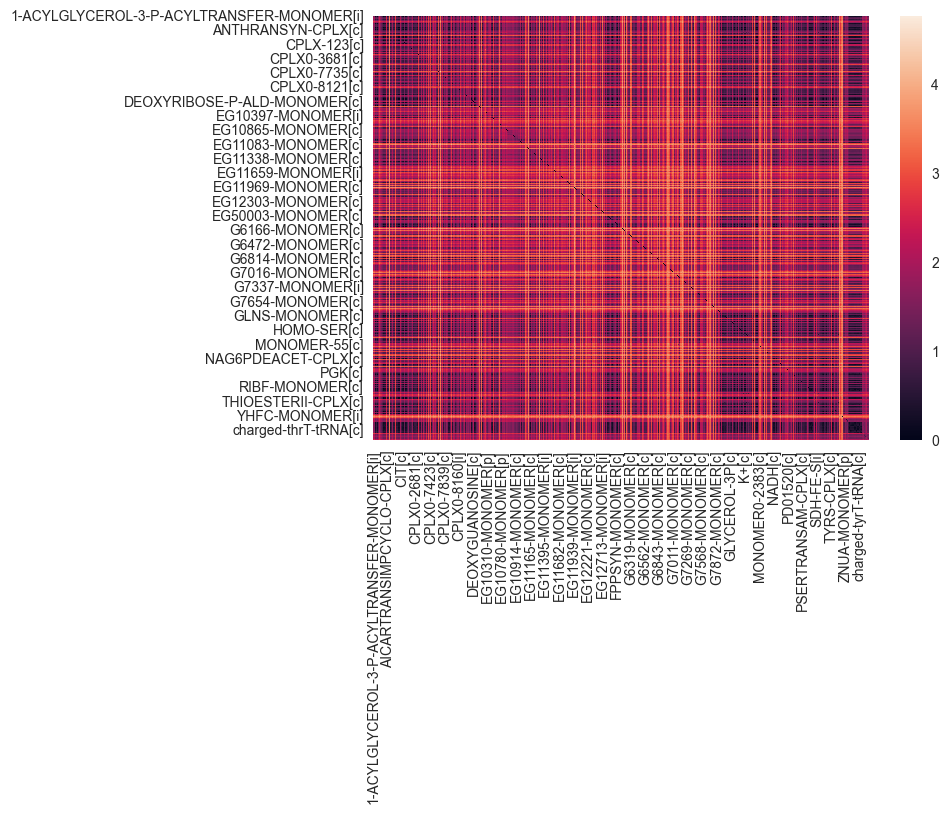

In [53]:
sns.heatmap(avg_pairwise_euclidean_dist)

max pairwise dist:  108.7624136895541
cluster values:  [ 9 29  1 ... 12  6 16]
n clusters:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]


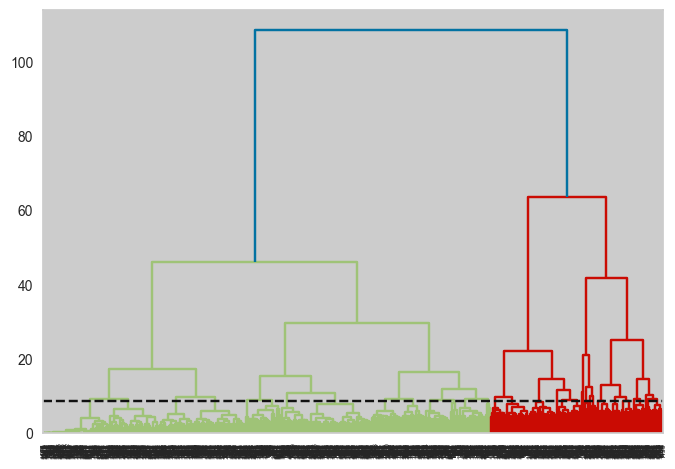

<AxesSubplot: >

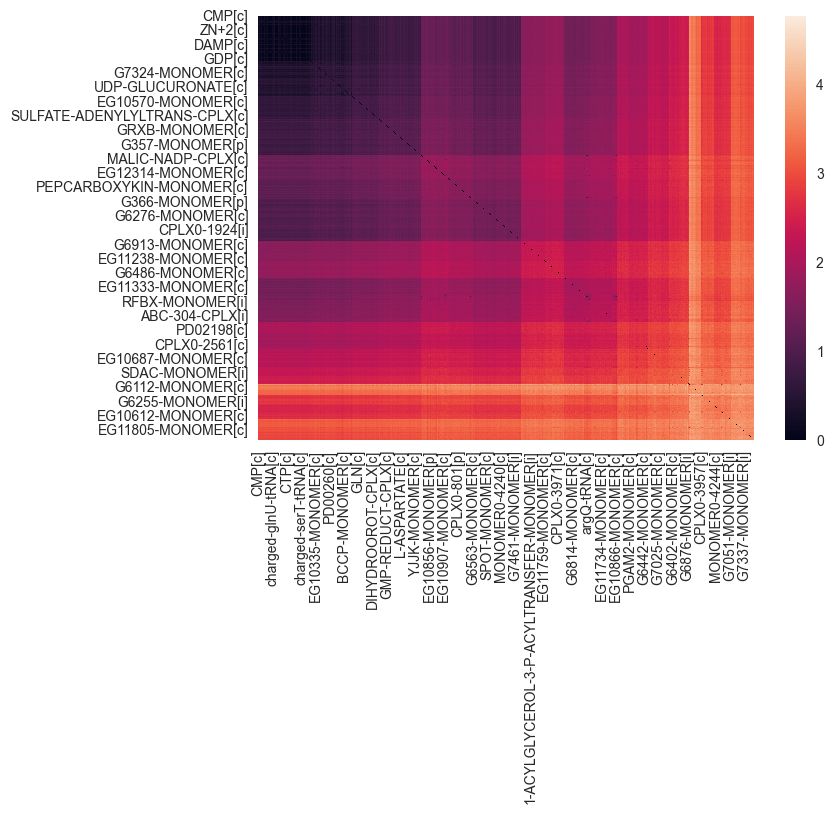

In [54]:
clustered_pairwise_euclidean_cost_matrix, euclidean_clusters_idx = cluster_corr(avg_pairwise_euclidean_dist, threshold_ratio=0.08)
sns.heatmap(clustered_pairwise_euclidean_cost_matrix)

In [55]:
# Create new column containing cluster labels
unique_euclidean_clusters = np.unique(euclidean_clusters_idx)
clustered_pairwise_euclidean_cost_matrix['cluster'] = euclidean_clusters_idx

selected_bms = []
for label in unique_euclidean_clusters:
    first_bm = clustered_pairwise_euclidean_cost_matrix.loc[clustered_pairwise_euclidean_cost_matrix['cluster'] == label].index.values[0]
    selected_bms.append(first_bm)

print(selected_bms)

['IMP[c]', 'charged-leuQ-tRNA[c]', 'RNA0-321[c]', 'charged-leuV-tRNA[c]', 'PHOSPHO-ENOL-PYRUVATE[c]', 'MALONYL-COA[c]', 'L-ORNITHINE[c]', 'K+[c]', 'CMP[c]', 'charged-glnX-tRNA[c]', 'INOSINE[c]', 'GLUC1PADENYLTRANS-CPLX[c]', 'charged-leuX-tRNA[c]', 'PYRUVATE[c]', 'MN+2[p]', 'charged-ileU-tRNA[c]', 'charged-leuP-tRNA[c]', 'MONOMER0-4230[c]', 'CPLX0-2021[c]', 'MG+2[c]', 'GLUTATHIONE[c]', 'G7559-MONOMER[i]', 'CPLX0-3950[c]', 'EG10044-MONOMER[i]', 'G7324-MONOMER[c]', 'CPLX0-7747[c]', 'EG10920-MONOMER[c]', 'G7211-MONOMER[c]', 'HYPOXANTHINE[c]', 'CPLX0-8196[c]', 'EG10899-MONOMER[c]', 'THIAMINE-PYROPHOSPHATE[c]', 'UMP[c]', '7-ALPHA-HYDROXYSTEROID-DEH-CPLX[c]', 'ACSERLYA-CPLX[c]']


In [56]:
euclidean_feature_selected_single_timepoint = scaled_single_timepoint[selected_bms]

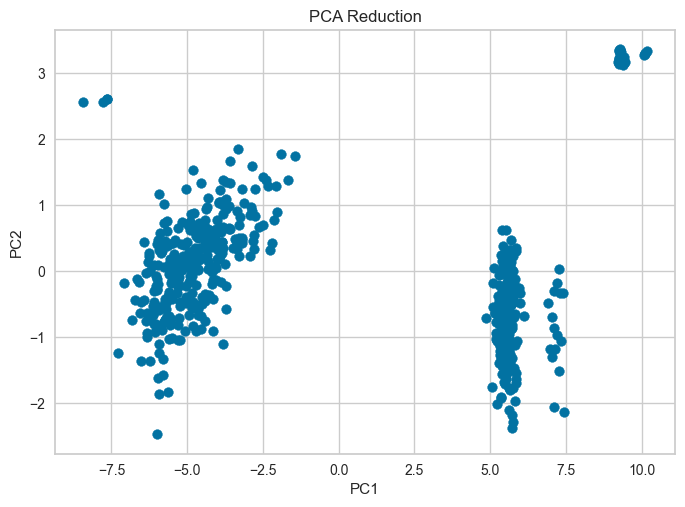

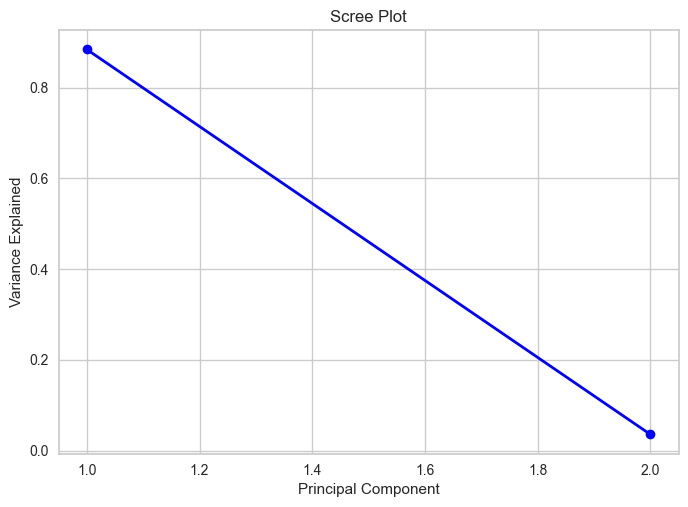

IMP[c]
35
                                         PC1       PC2
IMP[c]                              0.178907  0.056293
charged-leuQ-tRNA[c]                0.177831  0.049739
RNA0-321[c]                         0.177618  0.067041
charged-leuV-tRNA[c]                0.177558  0.068320
PHOSPHO-ENOL-PYRUVATE[c]            0.178907  0.056293
MALONYL-COA[c]                      0.178907  0.056293
L-ORNITHINE[c]                      0.178907  0.056292
K+[c]                               0.173997  0.079563
CMP[c]                              0.178907  0.056293
charged-glnX-tRNA[c]                0.177238  0.066556
INOSINE[c]                          0.178907  0.056293
GLUC1PADENYLTRANS-CPLX[c]           0.145649  0.155693
charged-leuX-tRNA[c]                0.177533  0.071852
PYRUVATE[c]                         0.178907  0.056293
MN+2[p]                             0.178907  0.056292
charged-ileU-tRNA[c]                0.177665  0.072401
charged-leuP-tRNA[c]                0.177767  0.048083


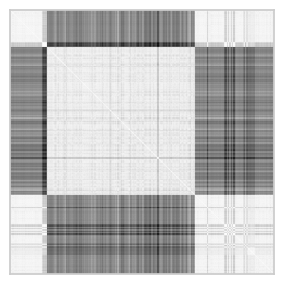

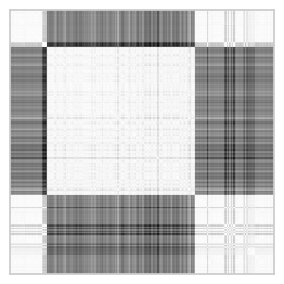

Residual Variance (using Pearson's r) =  0.01571665263934363
Residual Variance (using Spearman's r) =  0.05783505622055618
--- Ranking Matrices (R and Rz) ---


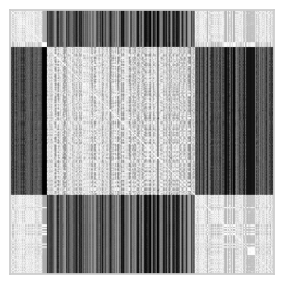

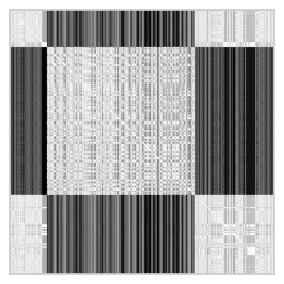

--- Co-ranking Matrix (Q) ---


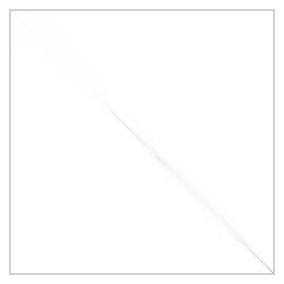

--- Trustworthiness T(k) and Continuity C(k) ---


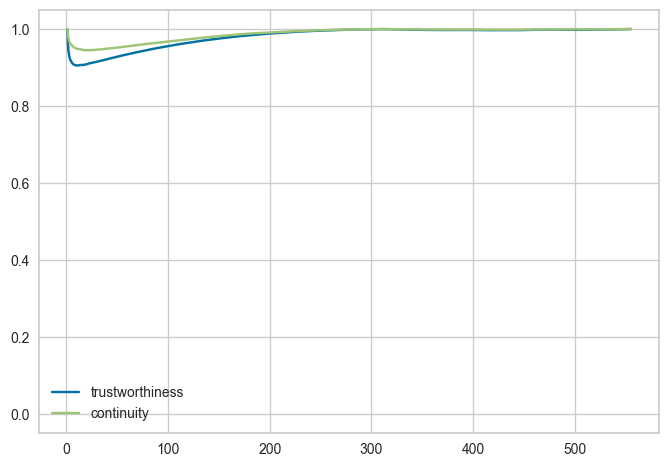

AUC of T =  0.9810970295335132
AUC of C =  0.9874371122165022
--- QNN(k) Curve ---


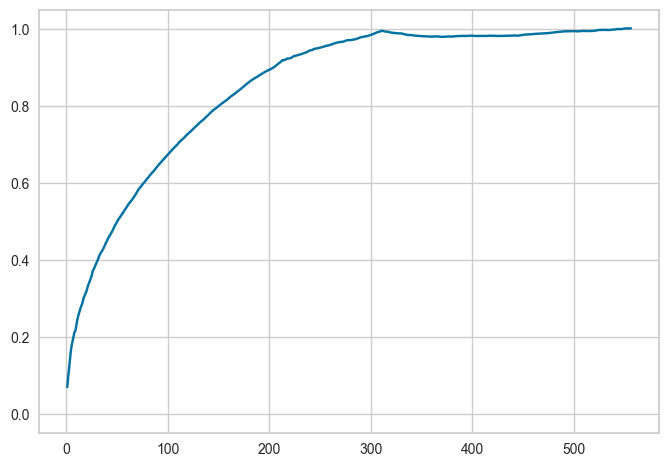

AUC of QNN =  0.8530600837542793
--- LCMC(k) Curve ---


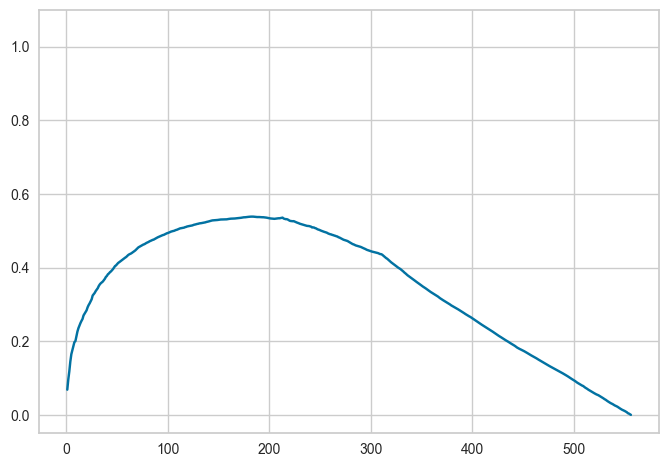

kmax (0-based index) =  182
Qlocal =  0.6091690152700501
Qglobal =  0.9723585641141677
None


In [57]:
reduced_euclidean_data = pca_reduction(euclidean_feature_selected_single_timepoint)

Time taken to generate ranking dataframe: 28.05s
Time taken to convert to matrix: 0.0s
Time taken to generate ranking dataframe: 27.13s
Time taken to convert to matrix: 0.0s
[[  0  25  51 ... 155 107 149]
 [ 69   0  80 ... 153  56  90]
 [135  99   0 ... 107 140 164]
 ...
 [186 159  95 ...   0  80 100]
 [166  48 117 ...  57   0  33]
 [188  77 128 ...  71  17   0]]
[[  0   1  53 ...  95 169  39]
 [  2   0  54 ...  92 169  40]
 [ 66  73   0 ... 142 165  17]
 ...
 [ 73  74 109 ...   0 191 125]
 [ 96  98  73 ... 150   0  56]
 [ 51  57  17 ... 145 138   0]]
R1 shape: (557, 557)
R2 shape: (557, 557)
--- Distance Matrices (D and Dz) ---


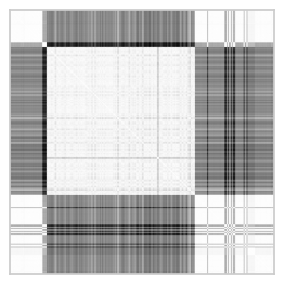

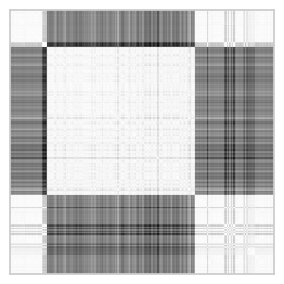

Residual Variance (using Pearson's r) =  0.031994850794647034
Residual Variance (using Spearman's r) =  0.08177786685263677
--- Ranking Matrices (R and Rz) ---


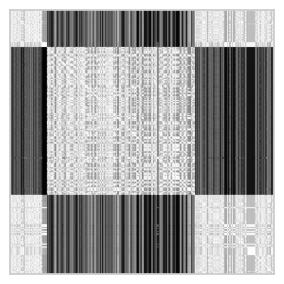

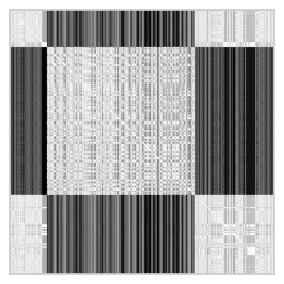

--- Co-ranking Matrix (Q) ---


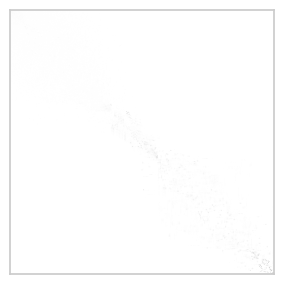

--- Trustworthiness T(k) and Continuity C(k) ---


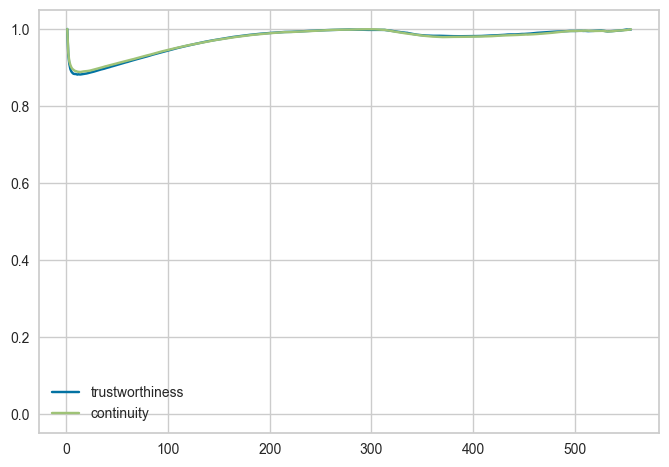

AUC of T =  0.9730885293368411
AUC of C =  0.9732654678713119
--- QNN(k) Curve ---


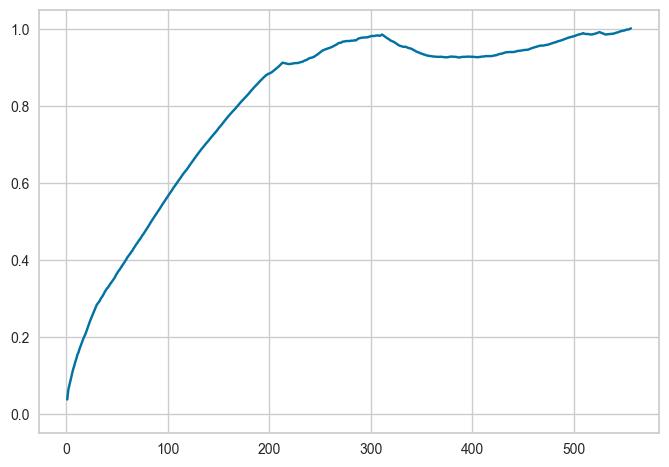

AUC of QNN =  0.8056704938948723
--- LCMC(k) Curve ---


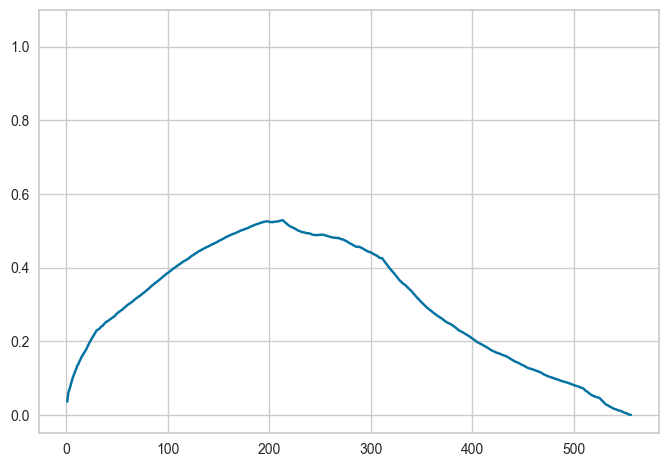

kmax (0-based index) =  212
Qlocal =  0.567449808908715
Qglobal =  0.9533436873394963
None


In [61]:
drm = DRMetrics(reduced_whole_data, reduced_euclidean_data)
print(drm.report()) # print out the summary

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

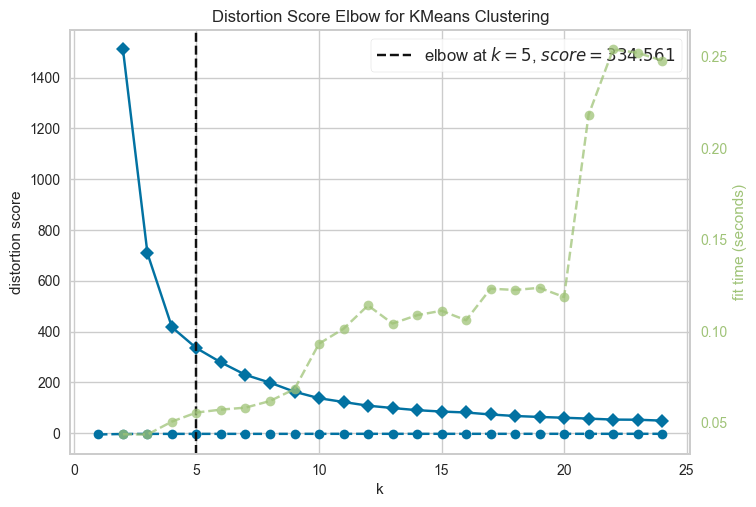

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

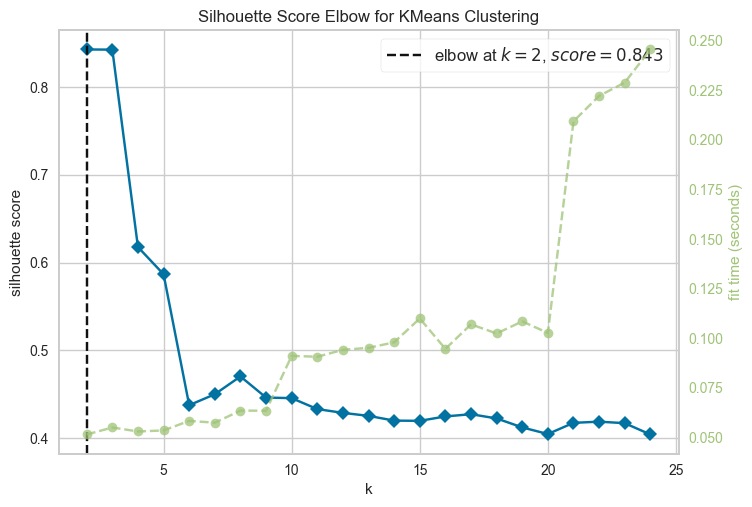

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

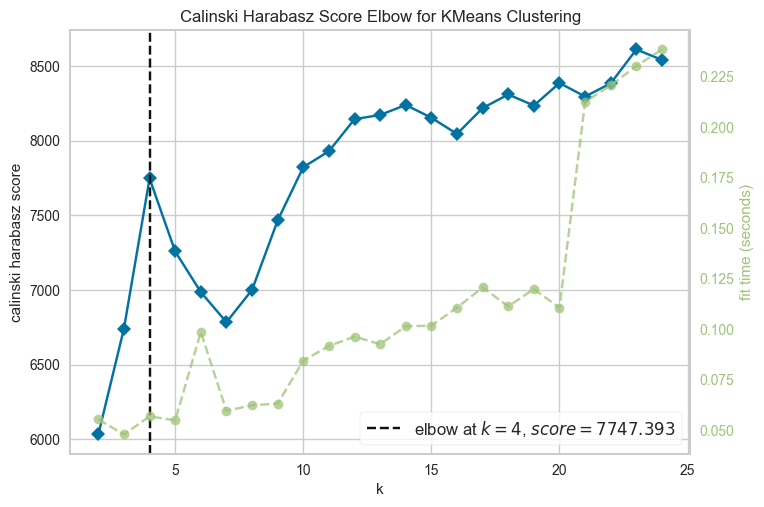

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\sklearn\clust

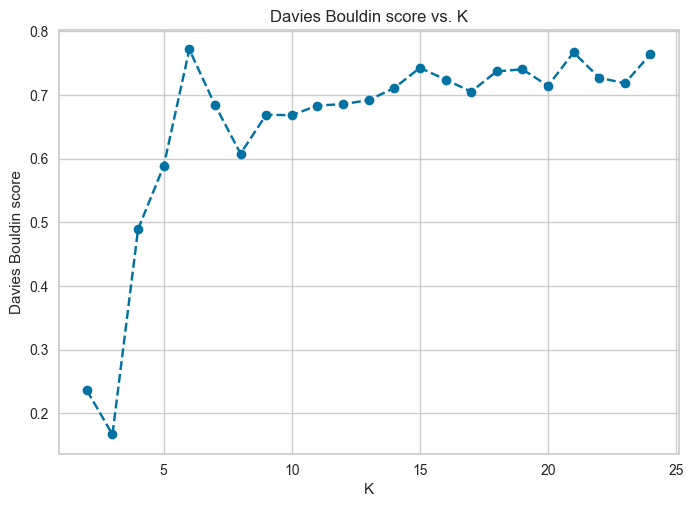

In [66]:

evaluate_kmeans(reduced_euclidean_data, max_clusters=25)


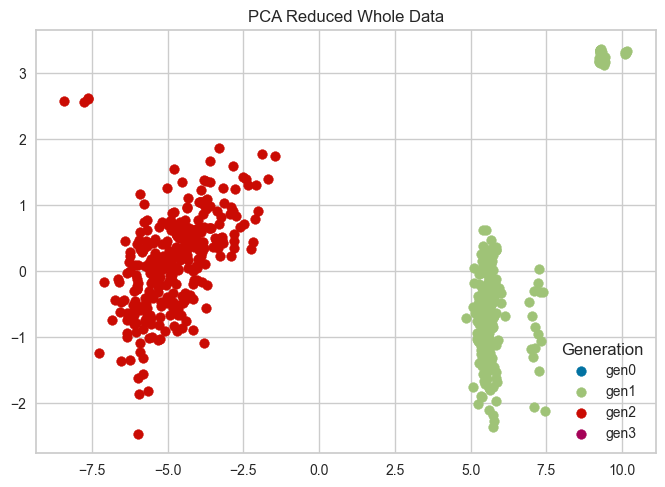

In [58]:
for gen in [0, 1, 2, 3]:
    generation_data = reduced_euclidean_data[data_slice.generation==gen]
    plt.scatter(generation_data[:, 0], generation_data[:, 1])
plt.title("PCA Reduced Whole Data")
plt.legend(['gen0', 'gen1', 'gen2', 'gen3'], title="Generation")
plt.show()

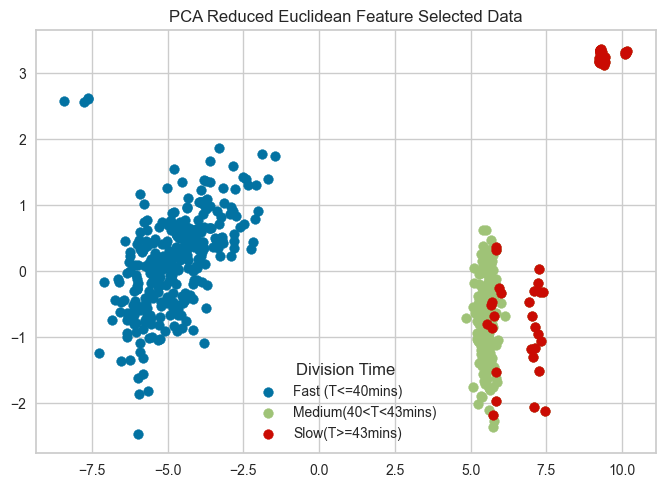

In [60]:
# Colour division time separately
fast_divisions = reduced_euclidean_data[data_slice.division_time <= 40]
medium_divisions = reduced_euclidean_data[data_slice.division_time > 40]
slow_divisions = reduced_euclidean_data[data_slice.division_time > 43]
plt.scatter(fast_divisions[:,0], fast_divisions[:,1])
plt.scatter(medium_divisions[:,0], medium_divisions[:,1])
plt.scatter(slow_divisions[:,0], slow_divisions[:,1])
plt.title("PCA Reduced Euclidean Feature Selected Data")
plt.legend(['Fast (T<=40mins)', 'Medium(40<T<43mins)', 'Slow(T>=43mins)'], title="Division Time")
plt.show()

In [ ]:
# UNIVARIATE FEATURE SELECTION

In [22]:
from sklearn.feature_selection import SelectKBest

In [50]:
# Mutual information regression
from sklearn.feature_selection import mutual_info_regression
k_best_regr = SelectKBest(mutual_info_regression, k=2)
minfo_regr_selected_data = k_best_regr.fit_transform(scaled_single_timepoint, data_slice.division_time)

In [52]:
print(minfo_regr_selected_data.shape)
print(minfo_regr_selected_data)
k_best_regr_series = pd.Series(data=k_best_regr.scores_, index=k_best_regr.feature_names_in_).sort_values()
print(k_best_regr_series)

(557, 2)
[[-0.94774686 -0.9752499 ]
 [-0.93183003 -0.95899153]
 [-0.97829417 -1.00605525]
 ...
 [-0.98593487 -1.01375659]
 [-0.96932061 -0.99707036]
 [-0.9818278  -1.00990592]]
CPLX0-3602[c]                    0.069846
CPLX0-3957[c]                    0.095526
G6424-MONOMER[c]                 0.102136
YDEA-MONOMER[i]                  0.105031
EG11158-MONOMER[c]               0.105790
                                   ...   
GUANOSINE[c]                     1.172305
ADENINE[c]                       1.172755
CYTIDINE[c]                      1.174527
RIBOSE-1P[c]                     1.175905
N-ACETYL-D-GLUCOSAMINE-1-P[c]    1.202389
Length: 1838, dtype: float64


In [55]:
print(k_best_regr_series.index[-1])

N-ACETYL-D-GLUCOSAMINE-1-P[c]


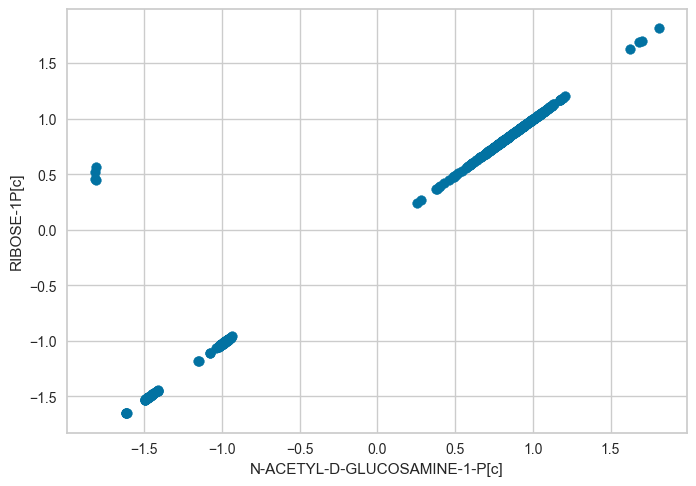

In [58]:
plt.scatter(minfo_regr_selected_data[:,0], minfo_regr_selected_data[:,1])
plt.xlabel(k_best_regr_series.index[-1])
plt.ylabel(k_best_regr_series.index[-2])
plt.show()

In [60]:
regr_df = pd.DataFrame(data=minfo_regr_selected_data, columns=[k_best_regr_series.index[-1], k_best_regr_series.index[-2]])
print(regr_df)

     N-ACETYL-D-GLUCOSAMINE-1-P[c]  RIBOSE-1P[c]
0                        -0.947747     -0.975250
1                        -0.931830     -0.958992
2                        -0.978294     -1.006055
3                        -0.995265     -1.023169
4                        -0.970948     -0.998782
..                             ...           ...
552                      -1.149272     -1.178907
553                      -0.995466     -1.023597
554                      -0.985935     -1.013757
555                      -0.969321     -0.997070
556                      -0.981828     -1.009906

[557 rows x 2 columns]


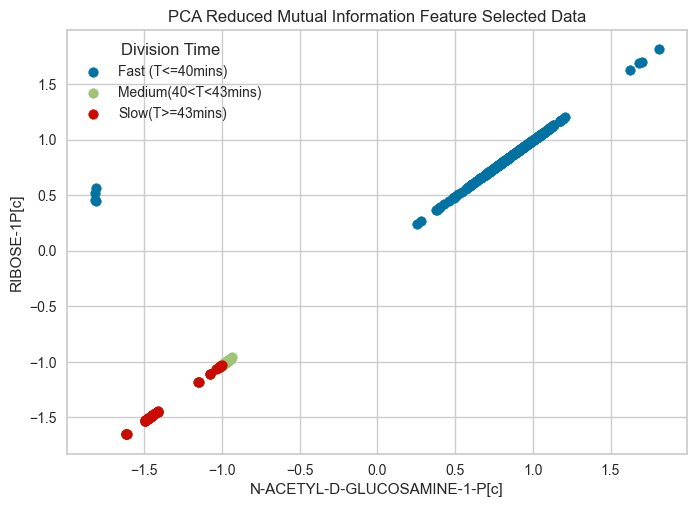

In [62]:
# Colour division time separately
fast_divisions = minfo_regr_selected_data[data_slice.division_time <= 40]
medium_divisions = minfo_regr_selected_data[data_slice.division_time > 40]
slow_divisions = minfo_regr_selected_data[data_slice.division_time > 43]
plt.scatter(fast_divisions[:,0], fast_divisions[:,1])
plt.scatter(medium_divisions[:,0], medium_divisions[:,1])
plt.scatter(slow_divisions[:,0], slow_divisions[:,1])
plt.title("PCA Reduced Mutual Information Feature Selected Data")
plt.legend(['Fast (T<=40mins)', 'Medium(40<T<43mins)', 'Slow(T>=43mins)'], title="Division Time")
plt.xlabel(k_best_regr_series.index[-1])
plt.ylabel(k_best_regr_series.index[-2])
plt.show()

In [ ]:
# N-ACETYL-D-GLUCOSAMINE-1-P[c] is a metabolite, a substance made or used when the body breaks down food, drugs or chemicals, or its own tissue (for example, fat or muscle tissue). This process, called metabolism, makes energy and the materials needed for growth, reproduction, and maintaining health.

In [41]:
# Mutual information classification
from sklearn.feature_selection import  mutual_info_classif
division_speed = data_slice.iloc[:,0].copy().apply(lambda x: int(len(x)>30))
print(division_speed)
print(division_speed.value_counts())
k_best_classif = SelectKBest(mutual_info_classif, k=2)
minfo_classif_selected_data = k_best_classif.fit_transform(scaled_single_timepoint, division_speed)
print(minfo_classif_selected_data.shape)
print(minfo_classif_selected_data)

8      1
9      1
23     1
24     1
38     1
      ..
597    1
611    1
612    1
626    1
627    1
Name: 1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i], Length: 557, dtype: int64
0    312
1    245
Name: 1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i], dtype: int64
(557, 2)
[[-0.89844368  1.39647064]
 [-0.82749347  1.4413107 ]
 [-1.09710427  1.35163058]
 ...
 [-0.82749347  1.21550896]
 [-1.02615406  1.41248495]
 [-0.91263372  1.18828464]]


In [42]:
print(minfo_classif_selected_data.shape)
print(minfo_classif_selected_data)
print(pd.Series(data=k_best_classif.scores_, index=k_best_classif.feature_names_in_).sort_values())

(557, 2)
[[-0.89844368  1.39647064]
 [-0.82749347  1.4413107 ]
 [-1.09710427  1.35163058]
 ...
 [-0.82749347  1.21550896]
 [-1.02615406  1.41248495]
 [-0.91263372  1.18828464]]
ARTI-MONOMER[p]               0.000000
EG10341-MONOMER[i]            0.000000
HISTPHOSTRANS-CPLX[c]         0.000000
CPLX0-3121[c]                 0.003814
PRIBFAICARPISOM-MONOMER[c]    0.005679
                                ...   
PRO[c]                        0.686794
EG12360-MONOMER[c]            0.686794
HOMO-CYS[c]                   0.686794
PGK[c]                        0.686794
PGLYCDEHYDROG-CPLX[c]         0.686794
Length: 1838, dtype: float64
